# <center>Итоговый проект "Определение социально уязвимых групп населения" #

 ## Часть 3. Кластеризация. ##

### 3.1 Загрузка и преобразование даных

In [17]:

# загрузим необходимые библиотеки
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from tools.clusters import plot_metrics
from tools.clusters import plot_coef

from sklearn import metrics
from sklearn.metrics import rand_score 
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score



In [18]:
# загрузим датасет с отобранными для анализа признаками
model_df = pd.read_csv(
    '/home/pavel/Work/Skill_Factory_DSPR/GitHub_Projects/Final_Project/Part_2/data/model_df.csv', index_col='region')

In [19]:
# произведем стандартизацию признаков с помощью StandardScaler
stand_scaler = StandardScaler()

scaler_df = stand_scaler.fit_transform(model_df)

scaler_df.shape

(85, 9)

### 3.2. Определение оптимальных параметров и внутренних метрик модели ML.

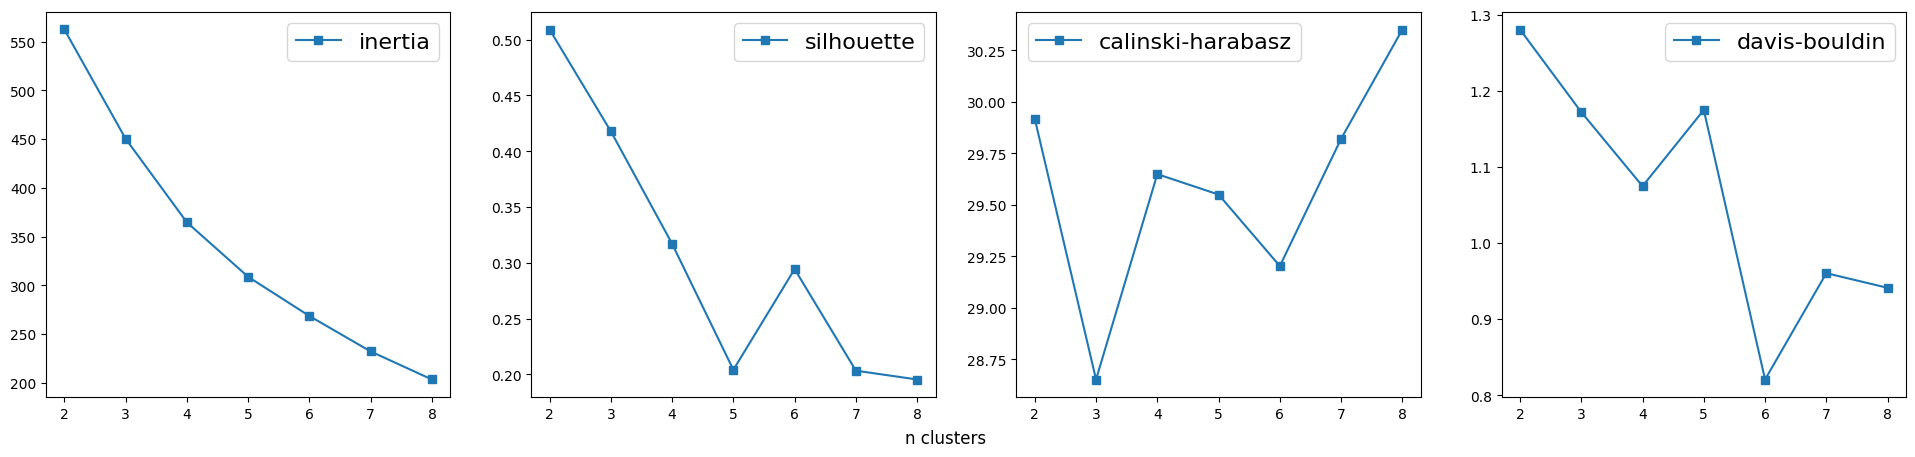

In [20]:
plot_metrics(scaler_df)

"Метод локтя" при оценке инерции и коэффициент Калински-Харабаса указывают на оптимальное колличество кластеров равное 4.Тогда как коэффициент 'силуэта' указывает на 5 кластеров, а коэффициент Дэвиса-Болдина на 6 кластеров. Примем значение числа кластеров равное 4.

Для сбора метрик моделей проекта в таблицу создадим списки моделей и метрик моделей.

Отобразим проекцию  семимерного признакового пространства  на плоскость используя t-SNE преобразование. Кроме того выведем значения кофициентов "силуэта", Калински-Харабаса и Дэвиса-Болдина для колличества кластеров - 4. 

Примем модель Kmeans за базовую для сравнения ее с другими моделями кластеризации. Метрикой оценки модели выберем rand_score (Индекс Рэнда рассчитывает меру сходства между двумя кластерингами,рассматривая все пары выборок и подсчитывая пары,которые приписываются одним и тем же или разным кластерам в предсказанных и истинных кластерингах. )

In [21]:
models=[]  # список моделей, которые я буду использовать в этом проекте
silhouette=[] # список коэффициентов "силуэта" моделей
calinski_harabasz=[] # список коэффициентов Калински-Харабаса моделей
davies_bouldin=[] # список коэффициентов Дэвиса_Болдина моделей
rand=[1.0] # список индексов Рэнда( первое значение будет равно 1 т.к. сходство кластеров модели сама с обой равна 1)

def make_metrics_lists(df,labels):    
    coef_silhouette = silhouette_score(df, labels)  
    coef_calinski_harabasz = calinski_harabasz_score(df, labels)  
    coef_davies_bouldin = davies_bouldin_score(df, labels)
    
    silhouette.append(coef_silhouette)
    calinski_harabasz.append(coef_calinski_harabasz)
    davies_bouldin.append(coef_davies_bouldin)

Коэфициент силуэта: 0.317
Коэфициент Калински-Харабаса: 29.649
Коэфициент Дэвиса-Болдина: 1.075


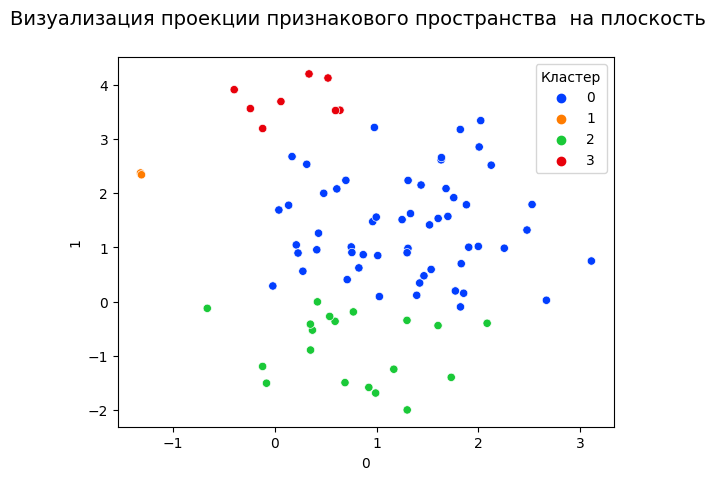

In [22]:
kmeans = KMeans(n_clusters=4, random_state=42)
bm_kmeans = kmeans.fit_predict(scaler_df) # примем модель Kmean за базовую для сравнения с другими

plot_coef(scaler_df, kmeans.labels_)
make_metrics_lists(scaler_df, kmeans.labels_)

models.append(bm_kmeans)

Уменьшим размерность данных методом главных компонент (PCA - principal component analysis). Найдем число главных компонент описывающих 90% дисперсии признакового поля данных. Алгоритм вычисления ***svd_solver*** выберем 'full'

Число главных компонент: 6


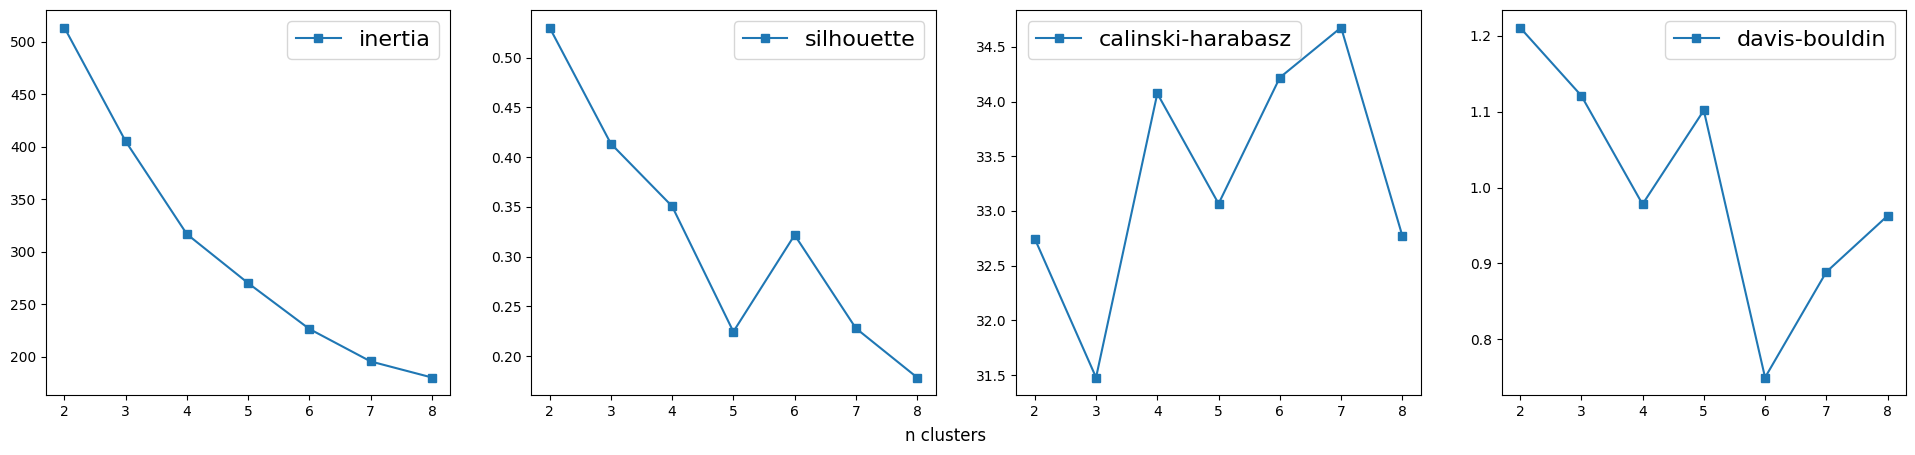

In [23]:
pca = PCA(n_components=0.9, svd_solver='full')
pca_df = pca.fit_transform(scaler_df)

plot_metrics(pca_df)
print(f'Число главных компонент: {pca.n_components_}')

Колличество главных компонент описывающих 90% дисперсии признаков оказалось равным 6. Применение метода главных компонент увеличило величину коэффициентов и незначительно изменило общую картину. Оствляем колличество кластеров равное 4.

Коэфициент силуэта: 0.351
Коэфициент Калински-Харабаса: 34.073
Коэфициент Дэвиса-Болдина: 0.978
Индекс Рэнда (сравнение с базовой моделью): 0.979


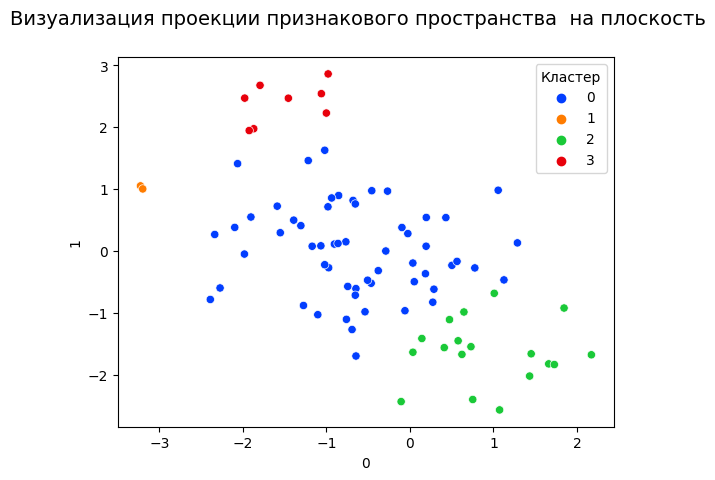

In [24]:
pca_kmeans = KMeans(n_clusters=4, random_state=42)
pca_kmeans.fit_predict(pca_df)

index_rand = rand_score(bm_kmeans, pca_kmeans.labels_)

plot_coef(pca_df, pca_kmeans.labels_)
make_metrics_lists(pca_df, pca_kmeans.labels_)

print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)

models.append(pca_kmeans)
rand.append(index_rand)

### 3.3. Сравнение с другими алгоритмами кластеризации ###

#### 3.3.1. Спектральная кластеризация

Коэфициент силуэта: 0.530
Коэфициент Калински-Харабаса: 21.285
Коэфициент Дэвиса-Болдина: 0.961
Индекс Рэнда (сравнение с базовой моделью): 0.676


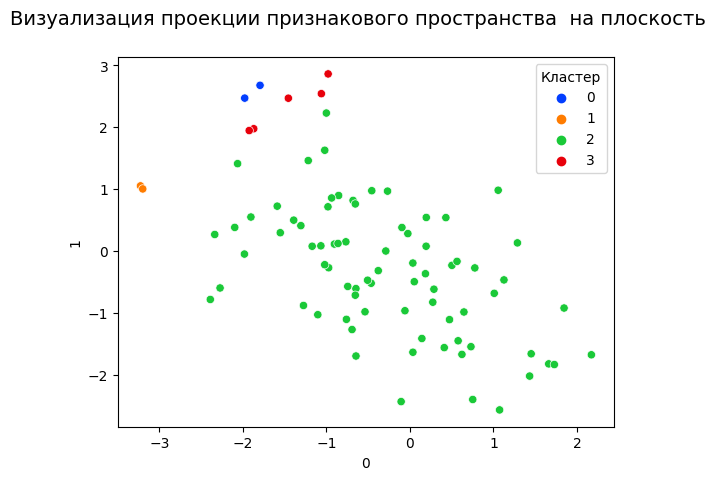

In [25]:
spectral = SpectralClustering(n_clusters=4)
labels = spectral.fit_predict(pca_df)

index_rand = rand_score(bm_kmeans, spectral.labels_)

plot_coef(pca_df, spectral.labels_)
make_metrics_lists(pca_df, spectral.labels_)

print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)

models.append(spectral)
rand.append(index_rand)

#### 3.3.2. Агломеративная кластеризация

Коэфициент силуэта: 0.462
Коэфициент Калински-Харабаса: 33.369
Коэфициент Дэвиса-Болдина: 0.925
Индекс Рэнда (сравнение с базовой моделью): 0.803


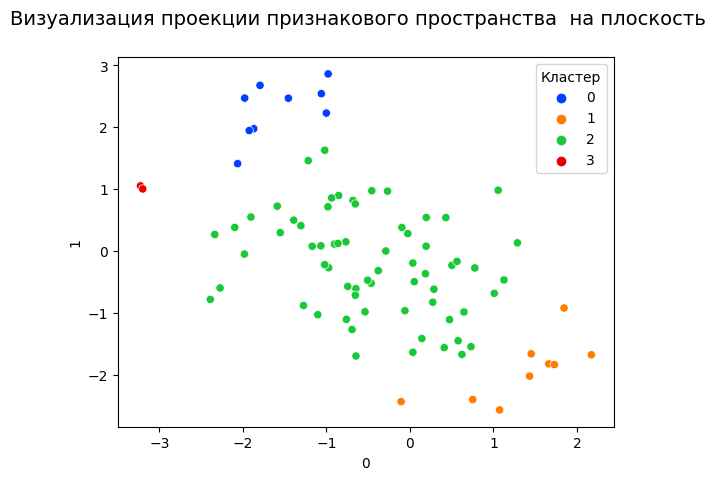

In [26]:
# наилучший вариант: linkage='ward'
agg_clust= AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = agg_clust.fit_predict(pca_df)

index_rand = rand_score(bm_kmeans, agg_clust.labels_)

plot_coef(pca_df, agg_clust.labels_)
make_metrics_lists(pca_df, agg_clust.labels_)

print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)

models.append(agg_clust)
rand.append(index_rand)

#### 3.3.3. Гауссова смесь

Коэфициент силуэта: 0.154
Коэфициент Калински-Харабаса: 23.001
Коэфициент Дэвиса-Болдина: 1.377
Индекс Рэнда (сравнение с базовой моделью): 0.689


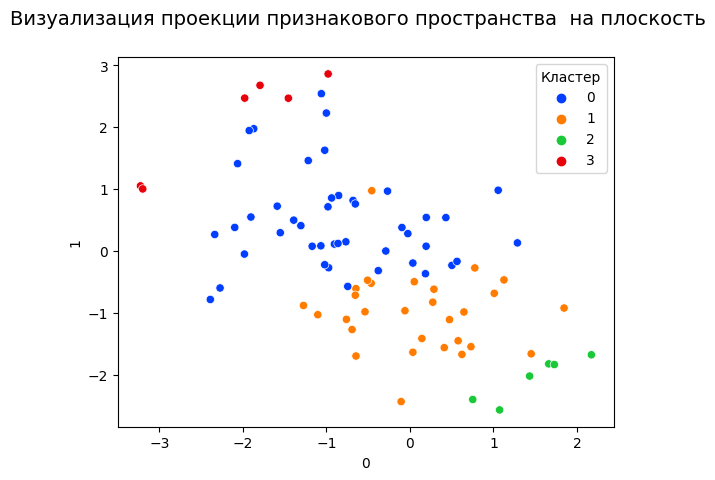

In [27]:
gaus_mix = GaussianMixture(
    n_components=4,
    random_state=42,
    covariance_type='tied'
)
labels = gaus_mix.fit_predict(pca_df)

index_rand = rand_score(bm_kmeans, labels)

plot_coef(pca_df, labels)
make_metrics_lists(pca_df, labels)

print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)

models.append(agg_clust)
rand.append(index_rand)

#### 3.3.4. Итоговая таблица метрик.

Построим для наглядности итоговую таблицу метрик:

In [28]:
d = {'model':['Base Kmeans','Kmeans+PSA', 'SpectralClustering+PCA',
              'AgglomerativeClustering+PCA', 'GaussianMixture+PCA'], 
                                          'Коэф."силуэта"': silhouette,
                                          'Коэф. Калински-Харабаса':calinski_harabasz,
                                          'Коэф. Дэвис-Болдина':davies_bouldin,
                                          'Индекс Рэнда':rand}
metrics_table = pd.DataFrame.from_dict(d, orient='index').T 
metrics_table

,model,"Коэф.""силуэта""",Коэф. Калински-Харабаса,Коэф. Дэвис-Болдина,Индекс Рэнда
0,Base Kmeans,0.317148,29.649195,1.074675,1.0
1,Kmeans+PSA,0.350615,34.073375,0.978146,0.979272
2,SpectralClustering+PCA,0.530454,21.284718,0.961367,0.67619
3,AgglomerativeClustering+PCA,0.462075,33.368761,0.9254,0.803081
4,GaussianMixture+PCA,0.154297,23.000616,1.377182,0.689076


В совокупности метрик кластеризации наилучший результат дает Агломеративноая кластеризация с понижения размерности методом главных компонент. Значение коэффициента "силуэта" достаточно большое среди наибольших значений (0.46), коэффициент Калински-Харабаса один из наибольших, коэфицциент Дэвиса-Болдина имеет минимальное значение.

Альтернативным вариантом кластеризации может являться KMeans с применением понижения размерности методом главных компонент.

#### 3.3.5. Сохранение модели кластеризации и датафрейма с метками кластеров. ####

In [29]:
 '''В моделе применим следующие этапы:
        - StandardScaler: стандартизация признакового поля данных;
        - PCA: понижение размерности методом главных компонент с сохранением дисперсии признаков 90%;
        - SpectralClustering: спектральная кластеризация.
'''
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.9, svd_solver='full')), ('agg_clust', AgglomerativeClustering(n_clusters=4))])

# сохраним модель в виде pickle-файла
with open('tools/model.pkl', 'wb') as n:
    pickle.dump(pipe, n)
    
# создадим метки кластеров
agg_clust= AgglomerativeClustering(n_clusters=4, linkage='ward')
model_df['cluster'] = agg_clust.fit_predict(pca_df) # метки кластеров

# упорядочим нумерацию кластеров по колличеству регионов
#model_df['cluster'] = model_df['cluster'].replace({0:0, 2:1, 1:2, 3:3})

# сохраним датафрейм с метками кластеров
model_df['cluster'].to_csv('./data/labels.csv')

# сохраним метки кластеров
model_df.to_csv('./data/df_labels.csv')

### <center> 4. Характеристика полученных кластеров

In [30]:
model_df.head(3)

,density,living_area,gdpp,spec_subsidies,welfare,retail,poverty_percent,living_wage,unemployment_rate,cluster
region,,,,,,,,,,
"('Алтайский край', 'Алтайский край')",13.792906,18.0,291156.9,32067.902020,29.7,153605,17.5,10904,5.9,2
"('Амурская область', 'Амурская область')",2.182997,17.3,571362.1,43050.621924,21.7,245233,15.2,14331,6.0,2
"('Архангельская область без Ненецкого АО', 'Архангельская область без Ненецкого АО')",2.644435,16.9,514200.4,38856.664512,21.4,250033,12.3,14507,7.4,2


In [31]:
model_df['cluster'].value_counts().sort_index()

0     9
1     9
2    65
3     2
Name: cluster, dtype: int64

In [32]:
# 0 Кластер

cluster_0 = list(model_df[model_df['cluster'] == 0].index)
print (', '.join(cluster_0))


('Камчатский край', 'Камчатский край'), ('Магаданская область', 'Магаданская область'), ('Московская область', 'Московская область'), ('Ненецкий автономный округ', 'Ненецкий автономный округ'), ('Республика Саха (Якутия)', 'Республика Саха (Якутия)'), ('Сахалинская область', 'Сахалинская область'), ('Ханты-Мансийский автономный округ - Югра', 'Ханты-Мансийский автономный округ - Югра'), ('Чукотский автономный округ', 'Чукотский автономный округ'), ('Ямало-Ненецкий автономный округ', 'Ямало-Ненецкий автономный округ')


In [ ]:
model_df[model_df['cluster'] == 0].describe()

In [ ]:
# 1 Кластер

cluster_1 = list(model_df[model_df['cluster'] == 1].index)
print (', '.join(cluster_1))

In [ ]:
model_df[model_df['cluster'] == 1].describe()

In [ ]:
# 2 Кластер

cluster_2 = list(model_df[model_df['cluster'] == 2].index)
print (', '.join(cluster_2))

In [ ]:
model_df[model_df['cluster'] == 2].describe()

In [ ]:
# 3 Кластер

cluster_3 = list(model_df[model_df['cluster'] == 3].index)
print (', '.join(cluster_3))

In [ ]:
model_df[model_df['cluster'] == 3].describe()

In [ ]:
title=['Плотность населения; чел./кв.км.','Среднедушевые доходы в месяц; руб.',
       'Валовой региональный продукт на душу населения; руб.','Расходы на социальную политику; %',
       'Объем розничной торговли; млн.руб.','Доля населения, живущих за чертой бедности; %',
       'Уровень безработицы; %']

cols = model_df[
    [
        'density',
        'per_capita',
        'gdpp',
        'welfare',
        'retail',
        'poverty_percent',
        'unemployment_rate'        
    ]
].columns.tolist()
plt.figure(figsize=(15, 15))

for i, variable in enumerate(cols):
    plt.subplot(7, 3, i + 1)
    sns.barplot(model_df['cluster'], model_df[variable], palette="spring")
    plt.tight_layout()
    plt.title(title[i].upper())
plt.show()

Проанализировав статистические характеристики кластеров, сравнив их между собой и для наглядности отобразив их в виде столбчатых диагарамм можно дать следующую характеристику кластерам:

 * ***кластер_0*** - самый большой по колличеству субъектов (69), с низкой плотностью населения (34,4 чел./кв.км.)характерной для большинства субъектов РФ, достаточными средними показателями дохода, валового регионального продукта, объема розничной торговли на душу населения, большой долей населения живущего за чертой бедности, но и, большими расходами на социальную политику, достаточно низким уровенем безработицы (6,4% населения);

 * ***кластер_1*** - колличество субъектов - 7, с плотностью населения (52 чел./кв.км.), самыми низкими с другими кластерами средними показателями дохода, валового регионального продукта, объема розничной торговли на душу населения, очень большой долей населения живущего за чертой бедности, но и, очень большими расходами на социальную политику и самым высоким уровенем безработицы (17,1% населения);

 * ***кластер_2*** - колличество субъектов - 7, с плотностью населения (26,2 чел./кв.км.), с самыми высокими средними показателями дохода, валового регионального продукта на душу населения, высоким средним показателем объема розничной торговли, небольшой долей населения живущего за чертой бедности, не очень большими расходами на социальную политику и не большим уровенем безработицы (4,8 % населения);

 * ***кластер_3*** - колличество субъектов - 2 (города федерального значения Москва и Санкт-Петербург), с плотностью населения ( 4399 чел./кв.км. !), с высокими средними показателями дохода, валового регионального продукта на душу населения, самым высоким средним показателем объема розничной торговли, минимальной долей населения живущего за чертой бедности,  большими расходами на социальную политику и минимальным уровенем безработицы (2,8 % населения).

Исходя из характеристики кластеров можно принять разделение регионов по уровню социальной защищенности:

   * ***кластер_0*** - субъекты со средним уровнем;

   * ***кластер_1*** - субъекты с низким уровнем;

   * ***кластер_2*** - субъекты с высоким уровнем;

   * ***кластер_3*** - субъекты с очень высоким уровнем.


Загрузим датафрейм с 27 признаками, присвоим регионам метки кластеров и сравним значения некоторых признаков между кластерами: 




In [ ]:
#  загрузим данные проекта в df
df = pd.read_csv(
    '/home/pavel/Work/Skill_Factory_DSPR/GitHub_Projects/Final_Project/Part_1/data/sp_df_2020.csv', index_col='region')

df['cluster'] = model_df['cluster']
df.head(3)



In [ ]:
# построим столбчатые диаграмы признаков сгруппированных по кластерам

title=['Средняя жилая площадь на одного человека; кв.км.',
       'Доля домохозяйств, не имеющих средств для улучшения жилищных условий',
       'Доля детей в возрасте до 16 лет живущих за чертой бедности; %',
       'Доля людей пенсионного возраста (более 60 лет) живущих за чертой бедности; %',
       'Доля людей работоспособного возраста (16-60 лет) живущих за чертой бедности; %',
       'Рождаемость; чел./год',
       'число зарегистрированных заболеваний у пациентов с диагнозом, установленном впервые в жизни',
       'число респираторных заболеваний (на 1 тыс. человек)',
       'число онкологических заболеваний (на 1 тыс. человек)',
       'число людей с инвалидностью']

cols = df[
    [
        'living area',
        'no funds',
        'children',
        'pensioners',
        'employable',
        'newborn',
        'morbidity',
        'respiratory',
        'neoplasms',
        'disabled'       
    ]
].columns.tolist()
plt.figure(figsize=(10, 25))

for i, variable in enumerate(cols):
    plt.subplot(10, 1, i + 1)
    sns.barplot(df['cluster'], df[variable], palette="spring")
    plt.tight_layout()
    plt.title(title[i].upper())
plt.show()